<a href="https://colab.research.google.com/github/PrathikNarayan/LSTMairpollutionforecasting/blob/main/air_pollution_forecasting_using_multivariate_lstms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing the required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

**series_to_supervised** function :- 

The function takes four arguments:

    data: Sequence of observations as a list or 2D NumPy array. 
    n_in: Number of lag observations as input (X). Values may be between [1..len(data)]. 
    n_out: Number of observations as output (y). Values may be between [0..len(data)-1]. 
    dropnan: Boolean whether or not to drop rows with NaN values. 

The function returns a single value:

    return: Pandas DataFrame of series framed for supervised learning.




In [ ]:
# If you run the function with simply your data, it will create a DataFrame with the default parameters of t-1.
# as X and t as y

def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    n_vars = 1 if type(data) is list else data.shape[1]
    
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

In [ ]:
df = pd.read_csv("LSTM-Multivariate_pollution.csv")

In [ ]:
df

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...,...
43795,2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43796,2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43797,2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43798,2014-12-31 22:00:00,8.0,-22,-4.0,1034.0,NW,246.72,0,0


In [ ]:
df.head


<bound method NDFrame.head of                       date  pollution  dew  temp   press wnd_dir  wnd_spd  \
0      2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79   
1      2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68   
2      2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57   
3      2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36   
4      2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25   
...                    ...        ...  ...   ...     ...     ...      ...   
43795  2014-12-31 19:00:00        8.0  -23  -2.0  1034.0      NW   231.97   
43796  2014-12-31 20:00:00       10.0  -22  -3.0  1034.0      NW   237.78   
43797  2014-12-31 21:00:00       10.0  -22  -3.0  1034.0      NW   242.70   
43798  2014-12-31 22:00:00        8.0  -22  -4.0  1034.0      NW   246.72   
43799  2014-12-31 23:00:00       12.0  -21  -3.0  1034.0      NW   249.85   

       snow  rain  
0         0     0  
1    

In [ ]:
df["wnd_dir"].unique()

array(['SE', 'cv', 'NW', 'NE'], dtype=object)

In [ ]:
# Encoding the string based data feature into integers

def func(s):
    if s == "SE":
        return 1
    elif s == "NE":
        return 2
    elif s == "NW":
        return 3
    else:
        return 4

df["wind_dir"] = df["wnd_dir"].apply(func)

In [ ]:
del df["wnd_dir"]

# Data Visualization

In [ ]:
df

,date,pollution,dew,temp,press,wnd_spd,snow,rain,wind_dir
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,1
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,1
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,1
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,1
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,1
...,...,...,...,...,...,...,...,...,...
43795,2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,231.97,0,0,3
43796,2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,237.78,0,0,3
43797,2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,242.70,0,0,3
43798,2014-12-31 22:00:00,8.0,-22,-4.0,1034.0,246.72,0,0,3


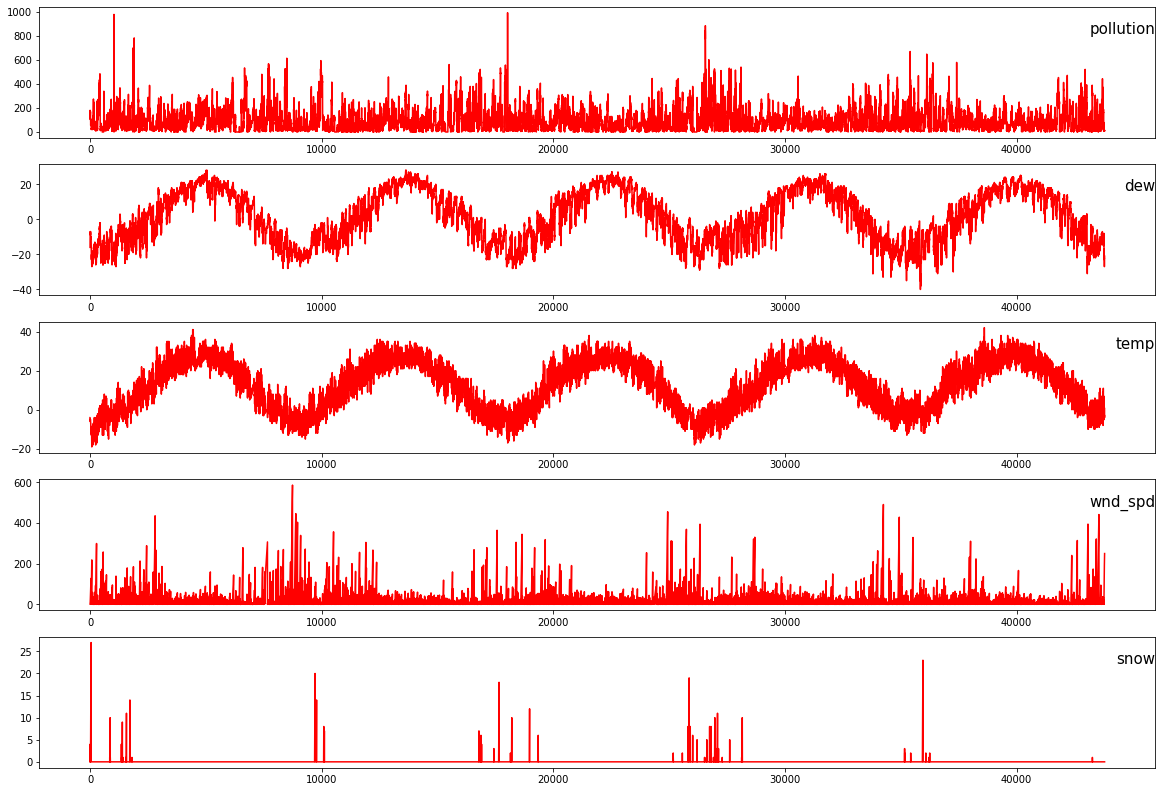

In [ ]:
values = df.values

# specify columns to plot
groups = [1, 2, 3, 5, 6]
i = 1

# plot each column
plt.figure(figsize=(20,14))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group], c = "red")
    plt.title(df.columns[group], y=0.75, loc='right', fontsize = 15)
    i += 1
plt.show()

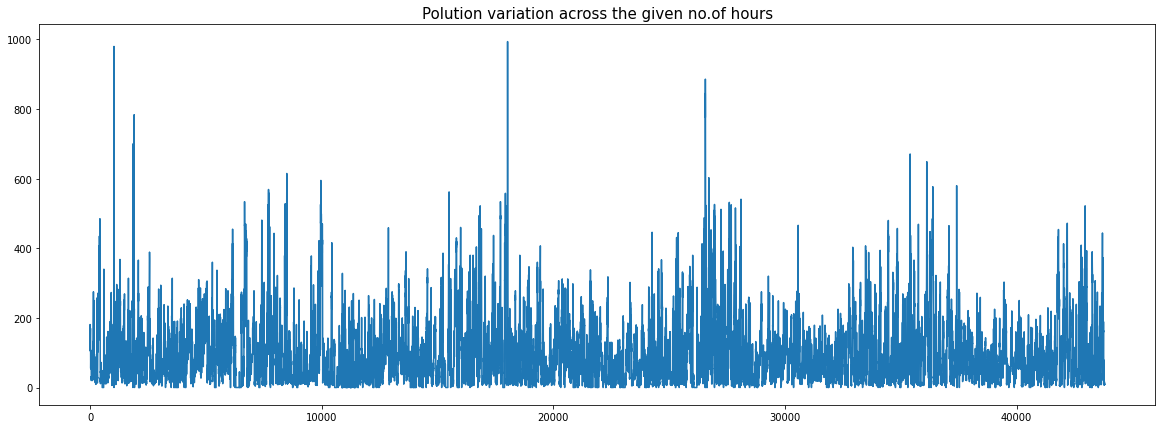

In [ ]:
fig = plt.figure(figsize = (20,7))
plt.plot(df.pollution)
plt.title("Polution variation across the given no.of hours", fontsize = 15)
plt.show()

In [ ]:
del df["date"]

In [ ]:
from sklearn.metrics import mean_absolute_error , mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Scaling the entire dataset

dataset = df
values = dataset.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [ ]:
# converting the dataset as supervised learning

reframed = series_to_supervised(scaled, 1, 1)
print(reframed.shape)

(43799, 16)


In [ ]:
print(reframed.head())

# Here, there are some unwanted data, which we don't want to predict, like var2(t), var3(3), ....

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.002290   0.000000   
2   0.148893   0.367647   0.245902   0.527273   0.003811   0.000000   
3   0.159960   0.426471   0.229508   0.545454   0.005332   0.000000   
4   0.182093   0.485294   0.229508   0.563637   0.008391   0.037037   
5   0.138833   0.485294   0.229508   0.563637   0.009912   0.074074   

   var7(t-1)  var8(t-1)   var1(t)   var2(t)   var3(t)   var4(t)   var5(t)  \
1        0.0        0.0  0.148893  0.367647  0.245902  0.527273  0.003811   
2        0.0        0.0  0.159960  0.426471  0.229508  0.545454  0.005332   
3        0.0        0.0  0.182093  0.485294  0.229508  0.563637  0.008391   
4        0.0        0.0  0.138833  0.485294  0.229508  0.563637  0.009912   
5        0.0        0.0  0.109658  0.485294  0.213115  0.563637  0.011433   

    var6(t)  var7(t)  var8(t)  
1  0.000000      0.0      0.0  
2  0.000000      0.0      0.0  
3  0.037037   

In [ ]:
reframed.columns

Index(['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var6(t-1)', 'var7(t-1)', 'var8(t-1)', 'var1(t)', 'var2(t)', 'var3(t)',
       'var4(t)', 'var5(t)', 'var6(t)', 'var7(t)', 'var8(t)'],
      dtype='object')

In [ ]:
# droping columns we don't want to predict

reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.002290   0.000000   
2   0.148893   0.367647   0.245902   0.527273   0.003811   0.000000   
3   0.159960   0.426471   0.229508   0.545454   0.005332   0.000000   
4   0.182093   0.485294   0.229508   0.563637   0.008391   0.037037   
5   0.138833   0.485294   0.229508   0.563637   0.009912   0.074074   

   var7(t-1)  var8(t-1)   var1(t)  
1        0.0        0.0  0.148893  
2        0.0        0.0  0.159960  
3        0.0        0.0  0.182093  
4        0.0        0.0  0.138833  
5        0.0        0.0  0.109658  


### Splitting the training data given into training and testing data for now.

In [ ]:
values = reframed.values

# We train the model on the 1st 3 years and then test on the last year (for now)
n_train_hours = 365 * 24 * 3

train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D :- (no.of samples, no.of timesteps, no.of features)
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(26280, 1, 8) (26280,) (17519, 1, 8) (17519,)


In [ ]:
train.shape, test.shape, values.shape

((26280, 9), (17519, 9), (43799, 9))

# Designing some neural networks and training them

### Creating and testing on a model, which has about 64 LSTM units

In [ ]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

In [ ]:
model = Sequential()
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_split=0.2, verbose=2, shuffle=False)

Epoch 1/50
292/292 - 3s - loss: 0.0060 - val_loss: 0.0036 - 3s/epoch - 10ms/step
Epoch 2/50
292/292 - 1s - loss: 0.0019 - val_loss: 0.0020 - 633ms/epoch - 2ms/step
Epoch 3/50
292/292 - 1s - loss: 0.0011 - val_loss: 0.0010 - 603ms/epoch - 2ms/step
Epoch 4/50
292/292 - 1s - loss: 9.1344e-04 - val_loss: 7.5330e-04 - 672ms/epoch - 2ms/step
Epoch 5/50
292/292 - 1s - loss: 8.6917e-04 - val_loss: 6.7402e-04 - 617ms/epoch - 2ms/step
Epoch 6/50
292/292 - 1s - loss: 8.5410e-04 - val_loss: 6.4331e-04 - 603ms/epoch - 2ms/step
Epoch 7/50
292/292 - 1s - loss: 8.4802e-04 - val_loss: 6.2858e-04 - 632ms/epoch - 2ms/step
Epoch 8/50
292/292 - 1s - loss: 8.4455e-04 - val_loss: 6.1772e-04 - 671ms/epoch - 2ms/step
Epoch 9/50
292/292 - 1s - loss: 8.4153e-04 - val_loss: 6.0689e-04 - 652ms/epoch - 2ms/step
Epoch 10/50
292/292 - 1s - loss: 8.3939e-04 - val_loss: 5.9781e-04 - 681ms/epoch - 2ms/step
Epoch 11/50
292/292 - 1s - loss: 8.3850e-04 - val_loss: 5.9113e-04 - 595ms/epoch - 2ms/step
Epoch 12/50
292/292 - 1

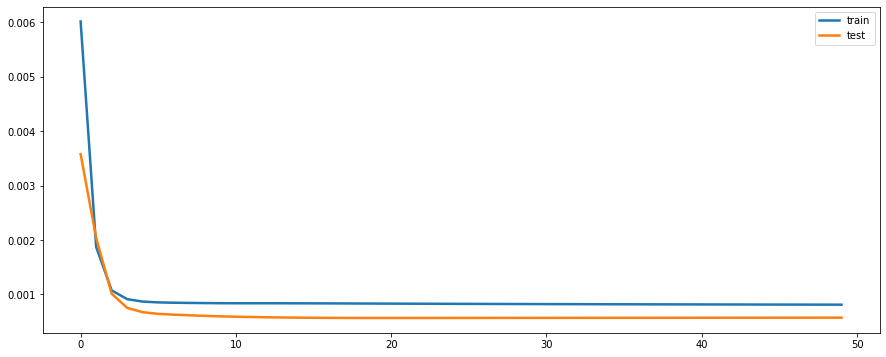

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='train', linewidth = 2.5)
plt.plot(history.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [ ]:
test_X.shape

(17519, 1, 8)

In [ ]:
testPredict = model.predict(test_X)
print(testPredict.shape)
testPredict = testPredict.ravel()

print(testPredict.shape)

(17519, 1)
(17519,)


In [ ]:
test.shape

(17519, 9)

In [ ]:
print(test), print(test.shape)

[[0.03521127 0.44117647 0.22950819 ... 0.         0.6666666  0.03118712]
 [0.03118712 0.4264706  0.1967213  ... 0.         0.6666666  0.03219316]
 [0.03219316 0.4264706  0.1967213  ... 0.         0.6666666  0.02112676]
 ...
 [0.01006036 0.2647059  0.26229507 ... 0.         0.6666666  0.01006036]
 [0.01006036 0.2647059  0.26229507 ... 0.         0.6666666  0.00804829]
 [0.00804829 0.2647059  0.24590163 ... 0.         0.6666666  0.01207243]]
(17519, 9)


(None, None)

In [ ]:
y_test_true = test[:,8]

In [ ]:
poll = np.array(df["pollution"])

meanop = poll.mean()
stdop = poll.std()

y_test_true = y_test_true*stdop + meanop
testPredict = testPredict*stdop + meanop

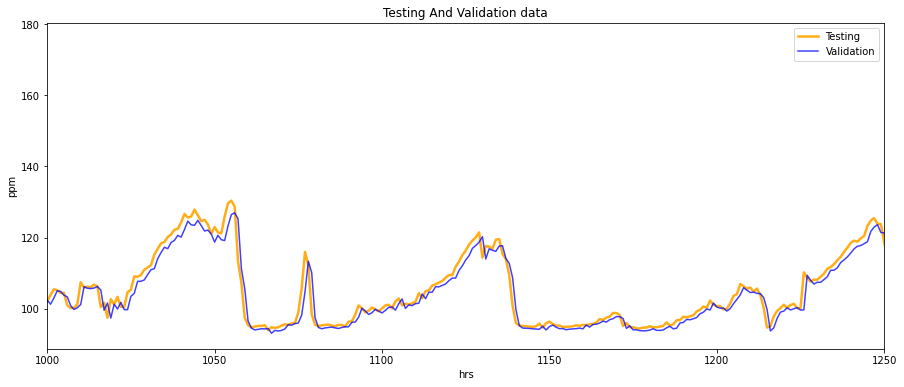

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,6))
plt.xlim([1000,1250])
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(y_test_true, c = "orange", alpha = 0.90, linewidth = 2.5)
plt.plot(testPredict, c = "blue", alpha = 0.75)
plt.legend(["Testing","Validation"])
plt.title("Testing And Validation data")
plt.show()

# testTrue = scaler.inverse_transform([testY]).ravel()

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test_true, testPredict))
print("Test(Validation) RMSE =",rmse)

# As we see the,  RMSE for testing data is low, and visually as well, from the above plots, we can see that the basic model is able to
# predict the future values of pollution (in ppm) pretty well

Test(Validation) RMSE = 2.5857236


### Creating another model, with more LSTM units and an extra dense layer to fine tune the parameters 

In [ ]:
model2 = Sequential()
model2.add(LSTM(256, input_shape=(train_X.shape[1], train_X.shape[2])))
model2.add(Dense(64))
model2.add(Dropout(0.25))
model2.add(BatchNormalization())
model2.add(Dense(1))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 256)               271360    
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 288,129
Trainable params: 288,001
Non-trainable params: 128
______________________________________________

In [ ]:
model2.compile(loss='mse', optimizer='adam')

hist2 = model2.fit(train_X, train_y, epochs=50, batch_size=128, validation_data=(test_X, test_y))

Epoch 1/50
206/206 [==============================] - 5s 14ms/step - loss: 0.0121 - val_loss: 0.0080
Epoch 2/50
206/206 [==============================] - 3s 16ms/step - loss: 0.0016 - val_loss: 0.0059
Epoch 3/50
206/206 [==============================] - 2s 11ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 4/50
206/206 [==============================] - 2s 11ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 5/50
206/206 [==============================] - 2s 11ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 6/50
206/206 [==============================] - 2s 12ms/step - loss: 0.0015 - val_loss: 0.0039
Epoch 7/50
206/206 [==============================] - 3s 14ms/step - loss: 0.0014 - val_loss: 0.0029
Epoch 8/50
206/206 [==============================] - 2s 11ms/step - loss: 0.0012 - val_loss: 7.1462e-04
Epoch 9/50
206/206 [==============================] - 2s 11ms/step - loss: 0.0013 - val_loss: 7.8679e-04
Epoch 10/50
206/206 [==============================] - 2s 11ms/step - loss: 0.0012 

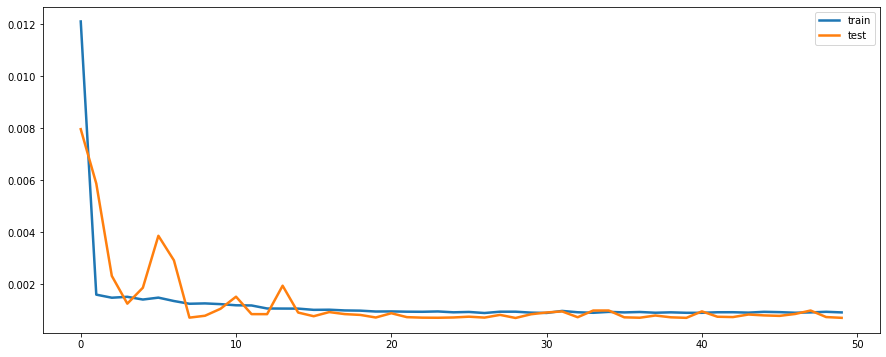

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(hist2.history['loss'], label='train', linewidth = 2.5)
plt.plot(hist2.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [ ]:
y_test_true = test[:,8]

In [ ]:
testPredict2 = model2.predict(test_X)
testPredict2 = testPredict2.ravel()

# Inverse scaling the output, for better visual interpretation 

poll = np.array(df["pollution"])
meanop = poll.mean()
stdop = poll.std()

print(meanop, stdop)

y_test_true = y_test_true*stdop + meanop
testPredict2 = testPredict2*stdop + meanop

94.01351598173515 92.25122315439845


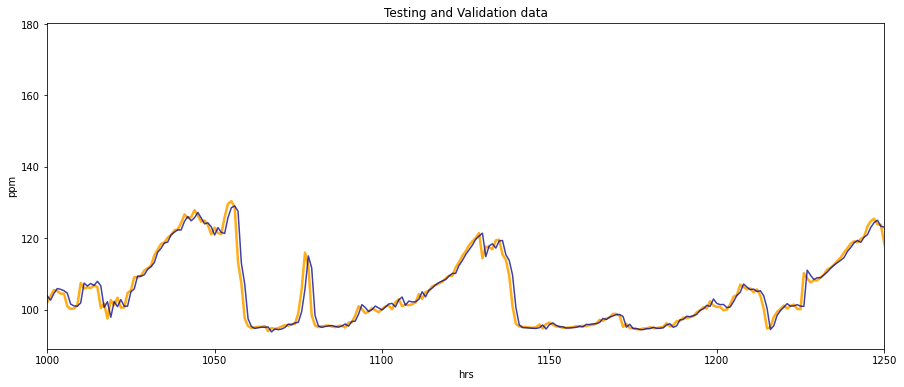

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,6))
plt.xlim([1000,1250])
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(y_test_true, c = "orange", alpha = 0.90, linewidth = 2.5)
plt.plot(testPredict2, c = "darkblue", alpha = 0.75)
plt.title("Testing and Validation data")
plt.show()

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test_true, testPredict2))
print("Test and Validation RMSE ="  ,rmse)

Test and Validation RMSE = 2.4526236


# Training on the complete training dataset and testing on the test dataset given

In [ ]:
values.shape

(43799, 9)

In [ ]:
values

array([[0.12977867, 0.35294122, 0.24590163, ..., 0.        , 0.        ,
        0.14889336],
       [0.14889336, 0.36764708, 0.24590163, ..., 0.        , 0.        ,
        0.15995975],
       [0.15995975, 0.4264706 , 0.22950819, ..., 0.        , 0.        ,
        0.18209255],
       ...,
       [0.01006036, 0.2647059 , 0.26229507, ..., 0.        , 0.6666666 ,
        0.01006036],
       [0.01006036, 0.2647059 , 0.26229507, ..., 0.        , 0.6666666 ,
        0.00804829],
       [0.00804829, 0.2647059 , 0.24590163, ..., 0.        , 0.6666666 ,
        0.01207243]], dtype=float32)

In [ ]:
train_x, train_y = values[:, :-1], values[:, -1]
print(train_x.shape, train_y.shape)

(43799, 8) (43799,)


In [ ]:
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))

In [ ]:
model3 = Sequential()
model3.add(LSTM(256, input_shape=(train_x.shape[1], train_x.shape[2])))
model3.add(Dense(32))
model3.add(Dropout(0.25))
model3.add(BatchNormalization())
model3.add(Dense(1))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 256)               271360    
                                                                 
 dense_3 (Dense)             (None, 32)                8224      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 279,745
Trainable params: 279,681
Non-trainable params: 64
_______________________________________________

In [ ]:
model3.compile(loss='mse', optimizer='adam')

hist3 = model3.fit(train_x, train_y, epochs=50, batch_size=256, validation_split=0.2)

Epoch 1/50
137/137 [==============================] - 5s 18ms/step - loss: 0.0071 - val_loss: 0.0079
Epoch 2/50
137/137 [==============================] - 2s 15ms/step - loss: 0.0013 - val_loss: 0.0070
Epoch 3/50
137/137 [==============================] - 2s 15ms/step - loss: 0.0013 - val_loss: 0.0052
Epoch 4/50
137/137 [==============================] - 2s 14ms/step - loss: 0.0013 - val_loss: 0.0035
Epoch 5/50
137/137 [==============================] - 2s 15ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 6/50
137/137 [==============================] - 2s 14ms/step - loss: 0.0012 - val_loss: 8.5071e-04
Epoch 7/50
137/137 [==============================] - 2s 14ms/step - loss: 0.0012 - val_loss: 7.9271e-04
Epoch 8/50
137/137 [==============================] - 2s 15ms/step - loss: 0.0012 - val_loss: 7.1614e-04
Epoch 9/50
137/137 [==============================] - 2s 15ms/step - loss: 0.0012 - val_loss: 7.3839e-04
Epoch 10/50
137/137 [==============================] - 2s 15ms/step - loss:

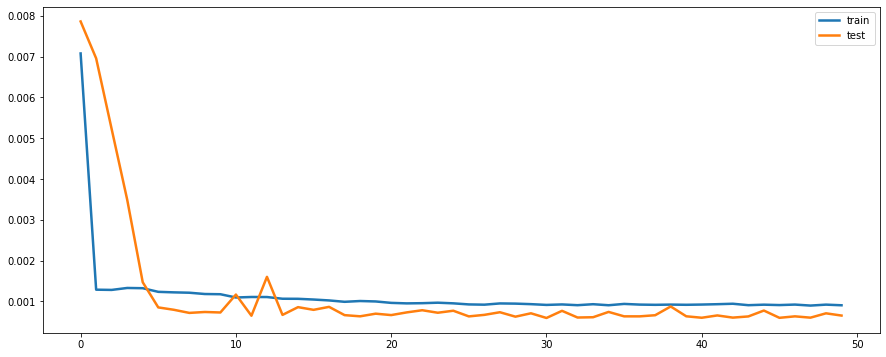

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(hist3.history['loss'], label='train', linewidth = 2.5)
plt.plot(hist3.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [ ]:
y_train_true = values[:,8]

In [ ]:
trainPredict3 = model3.predict(train_x)
trainPredict3 = trainPredict3.ravel()

# Inverse scaling the output, for better visual interpretation 

poll = np.array(df["pollution"])
meanop = poll.mean()
stdop = poll.std()

print(meanop, stdop)

y_train_true = y_train_true*stdop + meanop
trainPredict3 = trainPredict3*stdop + meanop

94.01351598173515 92.25122315439845


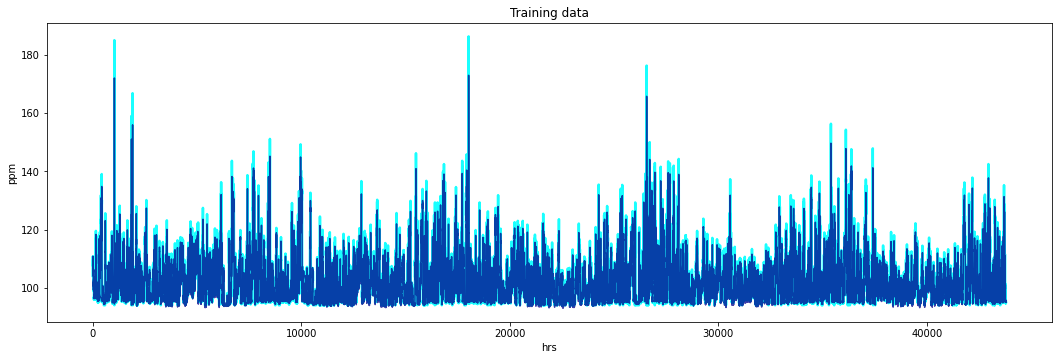

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize=(18,5.5))
# plt.xlim([1000,1250])
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(y_train_true, c = "cyan", alpha = 0.90, linewidth = 2.5)
plt.plot(trainPredict3, c = "darkblue", alpha = 0.75)
plt.title("Training data")
plt.show()

# darkblue

In [ ]:
rmse = np.sqrt(mean_squared_error(y_train_true, trainPredict3))
print("Training RMSE ="  ,rmse)

Training RMSE = 2.585187


### Testing phase for the model trained on the complete training dataset

Test data is converted into supervised data from time-series form, to feed it through the neural network trained model

In [ ]:
test_df = pd.read_csv("pollution_test_data1.csv")
test_df

,dew,temp,press,wnd_dir,wnd_spd,snow,rain,pollution
0,-16,4,1027,SE,3.58,0,0,128
1,-17,5,1027,SE,7.60,0,0,77
2,-16,4,1027,SE,9.39,0,0,65
3,-16,1,1028,cv,0.89,0,0,79
4,-14,0,1028,NE,1.79,0,0,93
...,...,...,...,...,...,...,...,...
341,-23,-2,1034,NW,231.97,0,0,8
342,-22,-3,1034,NW,237.78,0,0,10
343,-22,-3,1034,NW,242.70,0,0,10
344,-22,-4,1034,NW,246.72,0,0,8


In [ ]:
test_df["wind_dir"] = test_df["wnd_dir"].apply(func)
del test_df["wnd_dir"]

In [ ]:
values_test = test_df.values
values_test = values_test.astype('float32')

In [ ]:
scaler1 = MinMaxScaler()
scaled_test = scaler1.fit_transform(values_test)
reframed_test = series_to_supervised(scaled_test, 1, 1)

In [ ]:
reframed_test

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,0.523809,0.65,0.666668,0.007102,0.0,0.0,0.288288,0.000000,0.476190,0.70,0.666668,0.016223,0.0,0.0,0.173423,0.000000
2,0.476190,0.70,0.666668,0.016223,0.0,0.0,0.173423,0.000000,0.523809,0.65,0.666668,0.020285,0.0,0.0,0.146396,0.000000
3,0.523809,0.65,0.666668,0.020285,0.0,0.0,0.146396,0.000000,0.523809,0.50,0.708336,0.000998,0.0,0.0,0.177928,1.000000
4,0.523809,0.50,0.708336,0.000998,0.0,0.0,0.177928,1.000000,0.619048,0.45,0.708336,0.003040,0.0,0.0,0.209459,0.333333
5,0.619048,0.45,0.708336,0.003040,0.0,0.0,0.209459,0.333333,0.571429,0.35,0.750000,0.007102,0.0,0.0,0.234234,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,0.238095,0.35,0.916668,0.512128,0.0,0.0,0.022523,0.666667,0.190476,0.35,0.958336,0.525310,0.0,0.0,0.018018,0.666667
342,0.190476,0.35,0.958336,0.525310,0.0,0.0,0.018018,0.666667,0.238095,0.30,0.958336,0.538493,0.0,0.0,0.022523,0.666667
343,0.238095,0.30,0.958336,0.538493,0.0,0.0,0.022523,0.666667,0.238095,0.30,0.958336,0.549656,0.0,0.0,0.022523,0.666667
344,0.238095,0.30,0.958336,0.549656,0.0,0.0,0.022523,0.666667,0.238095,0.25,0.958336,0.558778,0.0,0.0,0.018018,0.666667


In [ ]:
reframed_test.drop(reframed_test.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed_test.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.523809       0.65   0.666668   0.007102        0.0        0.0   
2   0.476190       0.70   0.666668   0.016223        0.0        0.0   
3   0.523809       0.65   0.666668   0.020285        0.0        0.0   
4   0.523809       0.50   0.708336   0.000998        0.0        0.0   
5   0.619048       0.45   0.708336   0.003040        0.0        0.0   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.288288   0.000000  0.476190  
2   0.173423   0.000000  0.523809  
3   0.146396   0.000000  0.523809  
4   0.177928   1.000000  0.619048  
5   0.209459   0.333333  0.571429  


In [ ]:
values_test1 = reframed_test.values

test_x, test_y = values_test1[:, :-1], values_test1[:, -1]

test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

In [ ]:
test_x.shape, test_y.shape

((345, 1, 8), (345,))

In [ ]:
testPredict3 = model3.predict(test_x)
testPredict3 = testPredict3.ravel()
poll = np.array(df["pollution"])
meanop = poll.mean()
stdop = poll.std()

print(meanop, stdop)

# Inverse scaling the output, for better visual interpretation 
test_y = test_y*stdop + meanop
testPredict3 = testPredict3*stdop + meanop

94.01351598173515 92.25122315439845


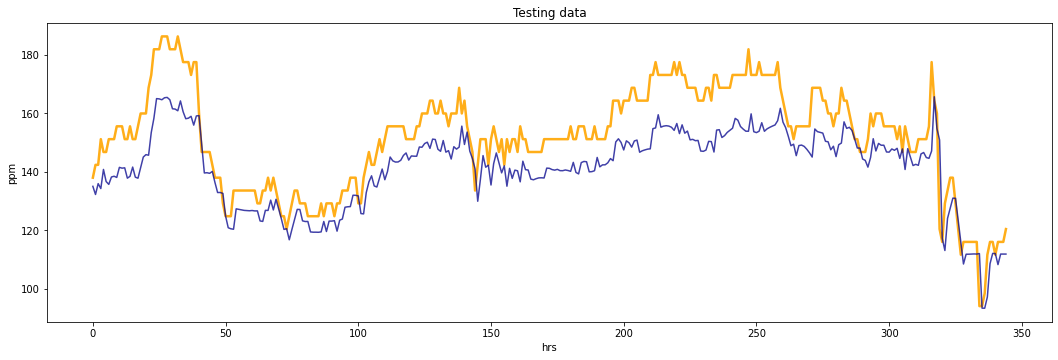

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize=(18,5.5))
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(test_y, c = "orange", alpha = 0.90, linewidth = 2.5)
plt.plot(testPredict3, c = "darkblue", alpha = 0.75)
plt.title("Testing data")
plt.show()


In [ ]:
rmse = np.sqrt(mean_squared_error(test_y, testPredict3))
print("Test RMSE ="  ,rmse)

Test RMSE = 12.4918995
